# **Regression**

## Objectives

* Fit and evaluate a regression model to predict the closing price of Bitcoin.

## Inputs

* outputs/datasets/cleaned/BTCAugmented.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Close
* Feature Importance Plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast'

# Load Cleaned Data

Section 1 content

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/BTCAugmentedV2.csv", index_col='date', parse_dates=True))

print(df.shape)
df.head(5)

(2650, 15)


,open,high,low,close,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,12EMA,26EMA,MACD,buy/sell
date,,,,,,,,,,,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19,377.9975,9.88,4.17,14.35,0.30,376.347692,376.312593,0.035100,1
2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33,376.3050,5.42,0.02,8.67,-3.23,375.884970,376.092401,-0.207430,0
2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56,377.5325,3.92,3.37,9.28,1.99,376.270360,376.262593,0.007766,1
2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53,378.9325,3.61,3.16,7.63,0.86,376.728766,376.483883,0.244883,1
2014-12-03,379.25,383.00,374.23,376.67,2998357.92,7908.29,378.2875,3.75,2.44,8.77,-2.58,376.719725,376.497669,0.222056,0


---

# MP Pipeline: Regressor

## Create ML pipeline

In [10]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ('numerical_transformation', vt.YeoJohnsonTransformer(variables=['open', 'high', 'low', 'Volume BTC', 'Volume USD', 
                         'price mean', 'upper shadow', 'lower shadow', 
                         'spread', '12EMA', '26EMA'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [11]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['close'], axis=1),
    df['close'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (2120, 14) (2120,) 
* Test set: (530, 14) (530,)


## Grid Search CV - Sklearn

Use default hyperparameters to find most suitable algorithm

In [13]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [14]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.735414,0.774869,0.819045,0.035448
2,RandomForestRegressor,0.706472,0.75856,0.805911,0.038643
3,ExtraTreesRegressor,0.706407,0.749811,0.799592,0.035636
6,XGBRegressor,0.605743,0.703395,0.782389,0.058332
1,DecisionTreeRegressor,0.539981,0.609183,0.650462,0.040267
4,AdaBoostRegressor,0.353095,0.442968,0.497109,0.048486
0,LinearRegression,0.328743,0.371711,0.394957,0.022542


## Extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search. 
Adjusted the parameter search ranges based on the best values already obtained during previous attempts
* ExtraTreesRegressor was removed in version 2 training

In [5]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html


params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [50, 100, 150],  
        'model__learning_rate': [0.05, 0.1, 0.01],  
        'model__max_depth': [3, 5],  
        'model__subsample': [0.8],  
    },
    "RandomForestRegressor": {
        'model__n_estimators': [200, 300, 500],  
        'model__max_depth': [5, 10],  
        'model__max_features': ['sqrt', 'log2'],  
        'model__min_samples_split': [5, 10], 
        'model__min_samples_leaf': [1, 2],  
    },
}

Extensive GridSearch CV

In [26]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Check results

In [27]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators,model__subsample,model__max_features,model__min_samples_leaf,model__min_samples_split
59,RandomForestRegressor,0.739311,0.780941,0.830707,0.034855,NaN,10,500,NaN,log2,1,10
47,RandomForestRegressor,0.739311,0.780941,0.830707,0.034855,NaN,10,500,NaN,sqrt,1,10
57,RandomForestRegressor,0.737313,0.780008,0.832014,0.03578,NaN,10,200,NaN,log2,1,10
45,RandomForestRegressor,0.737313,0.780008,0.832014,0.03578,NaN,10,200,NaN,sqrt,1,10
65,RandomForestRegressor,0.738688,0.779929,0.830934,0.034972,NaN,10,500,NaN,log2,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...
14,GradientBoostingRegressor,0.67212,0.717249,0.757436,0.033898,0.01,3,150,0.8,NaN,NaN,NaN
16,GradientBoostingRegressor,0.636617,0.676896,0.70346,0.027042,0.01,5,100,0.8,NaN,NaN,NaN
13,GradientBoostingRegressor,0.595619,0.639786,0.671207,0.03077,0.01,3,100,0.8,NaN,NaN,NaN
15,GradientBoostingRegressor,0.460537,0.494979,0.517491,0.021714,0.01,5,50,0.8,NaN,NaN,NaN


Check the best model

In [28]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Parameters for best model

In [29]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 10,
 'model__n_estimators': 500}

Define the best regressor, based on search

In [30]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('numerical_transformation',
                 YeoJohnsonTransformer(variables=['open', 'high', 'low',
                                                  'Volume BTC', 'Volume USD',
                                                  'price mean', 'upper shadow',
                                                  'lower shadow', 'spread',
                                                  '12EMA', '26EMA'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       min_samples_split=10, n_estimators=500,
                                       random_state=0))])

## Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['MACD', 'Volume USD']


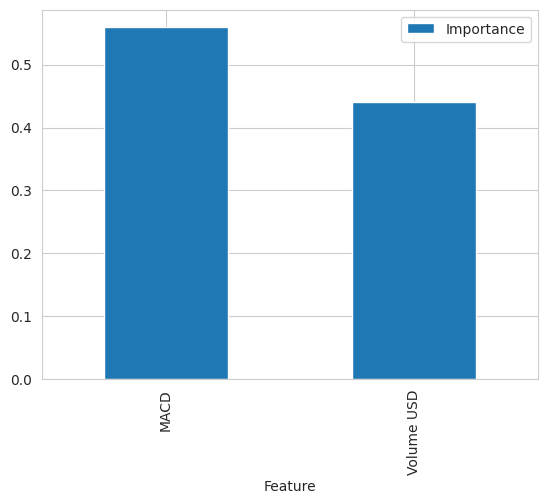

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluation: Verify metrics against the ML business case, ensuring an R² score of at least 0.7.

The model performs well with R² scores above 0.7 for both sets, but the Mean Absolute Error and Root Mean Squared Error suggest opportunities for improved prediction accuracy.

Model Evaluation 

* Train Set
R2 Score: 0.887
Mean Absolute Error: 2638.264
Mean Squared Error: 29628435.871
Root Mean Squared Error: 5443.201


* Test Set
R2 Score: 0.791
Mean Absolute Error: 3833.587
Mean Squared Error: 58260758.689
Root Mean Squared Error: 7632.874




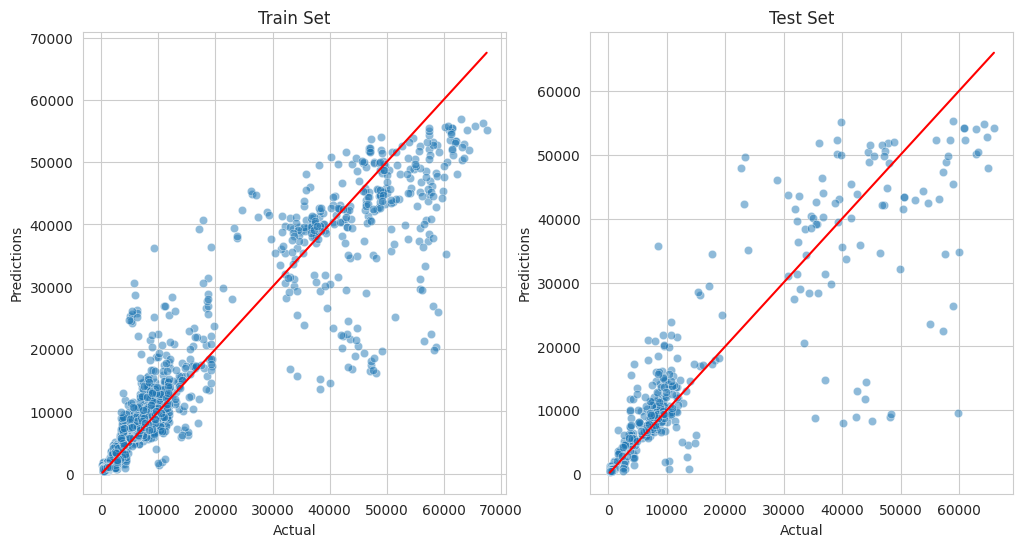

In [33]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [34]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_close/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [35]:
X_train.head()

,open,high,low,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,12EMA,26EMA,MACD,buy/sell
date,,,,,,,,,,,,,,
2018-12-09,3398.80,3633.20,3371.09,8.011023e+03,2.827691e+07,3483.2100,103.45,27.71,262.11,130.95,3770.752238,4285.087569,-514.335331,1
2021-09-13,46039.42,46895.82,43400.00,2.308422e+03,1.038198e+08,45327.3950,856.40,1574.34,3495.82,-1065.08,46881.459335,46911.440587,-29.981253,0
2021-09-24,44893.70,45159.90,40693.27,4.348928e+03,1.863451e+08,43398.8425,266.20,2155.23,4466.63,-2045.20,44963.376548,45865.868914,-902.492367,0
2015-12-13,436.08,442.97,422.03,4.885668e+06,1.122718e+04,434.2200,6.89,13.77,20.94,-0.28,408.189469,382.010012,26.179457,0
2017-09-19,4101.60,4119.70,3848.35,6.029694e+07,1.525189e+04,3989.6125,18.10,40.45,271.35,-212.80,3954.139445,4042.035241,-87.895796,0


In [36]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [37]:
y_train

date
2018-12-09     3529.75
2021-09-13    44974.34
2021-09-24    42848.50
2015-12-13      435.80
2017-09-19     3888.80
                ...   
2019-08-26    10360.97
2016-12-31      964.32
2017-03-13     1242.46
2019-06-09     7632.99
2022-01-18    42377.40
Name: close, Length: 2120, dtype: float64

In [38]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [39]:
X_test.head()

,open,high,low,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,12EMA,26EMA,MACD,buy/sell
date,,,,,,,,,,,,,,
2018-07-29,8231.07,8299.99,8109.74,3.980279e+03,3.270492e+07,8214.3850,68.92,107.00,190.25,-14.33,7803.793694,7376.078683,427.715011,0
2015-03-13,295.56,295.84,282.99,2.654225e+06,9.178740e+03,289.6975,0.28,1.41,12.85,-11.16,279.407035,266.290208,13.116826,0
2017-04-25,1253.58,1280.00,1251.07,6.651231e+06,5.249770e+03,1263.4125,11.00,2.51,28.93,15.42,1223.510976,1189.245905,34.265071,1
2016-07-02,674.55,704.93,672.74,3.759346e+06,5.431820e+03,688.6750,2.45,1.81,32.19,27.93,665.359802,644.774305,20.585498,1
2020-11-11,15314.94,15991.01,15290.85,1.001326e+04,1.572873e+08,15576.1725,283.12,24.09,700.16,392.95,14824.259163,13891.134053,933.125110,1


In [40]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [41]:
y_test

date
2018-07-29     8216.74
2015-03-13      284.40
2017-04-25     1269.00
2016-07-02      702.48
2020-11-11    15707.89
                ...   
2022-02-08    44091.56
2018-01-01    13443.41
2016-10-15      636.01
2016-03-29      415.40
2021-04-11    59979.26
Name: close, Length: 530, dtype: float64

In [42]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelin pipeline

ML pipeline for predicting close

In [43]:
best_regressor_pipeline

Pipeline(steps=[('numerical_transformation',
                 YeoJohnsonTransformer(variables=['open', 'high', 'low',
                                                  'Volume BTC', 'Volume USD',
                                                  'price mean', 'upper shadow',
                                                  'lower shadow', 'spread',
                                                  '12EMA', '26EMA'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       min_samples_split=10, n_estimators=500,
                                       random_state=0))])

In [44]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_close/v2/best_regressor_pipeline.pkl']

## Feature importance plot

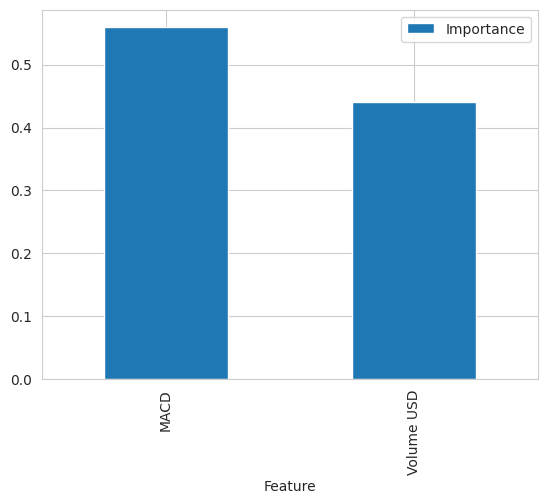

In [45]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

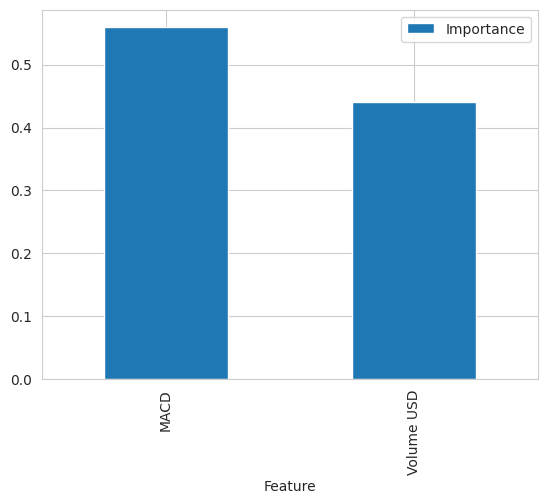

In [46]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')